# Assignment 3 part 2 

## Task HPV slides

## Data
There's a whole thesis written based on this dataset, available here: http://uu.diva-portal.org/smash/get/diva2:1650957/FULLTEXT01.pdf . The thesis then resulted in a paper: https://openaccess.thecvf.com/content_ICCV_2017_workshops/w1/html/Wieslander_Deep_Convolutional_Neural_ICCV_2017_paper.html


A quote from Weislander et al. regarding the dataset:

"The cell samples were collected at Södersjukhuset in Stockholm. The patients have mixed genders, are non smoking, some are human papillomavirus (HPV) positive and some are not, and they have an age span of 47-77 years. From each patient samples were collected with a brush that is scraped at areas of interest in the oral cavity. Each scrape is then smeared out on a glass, which is then stained to highlight important cellular structures"

## Notes
This assignment is inspired by Phil Harrisons lab for Pharmaceutical Bioinformatics and Sequence Analysis  from 2021

**You are not allowed to use the exact same network and configurations as in these texts, or as in your hand in for the mandatory assignment, but you are allowed to use the same base network if you are using transfer learning.**  

You may discuss theory with other groups, but not code nor share code. You may not use ChatGPT4 or similar programs to generate a solution or code.

 <span style="color:red"> Solutions deemed to similar will be run through a program designed to detect coding plagirism and if flagged you will be reported for plagirism. </span> 
 
 One hand in by the group.
 
 ## Hand in 2024
 Hand in one pdf file and one .ipynb file. The notebook must be runnable with the data, any teacher might run the notebook to check that it actually works. Notebooks that do not run will recieve no points
 
## 1 bonuspoint:
A neural network that achieve a 80% accuracy on the HPV data 

## 1 bonuspoint:
Answer the questions below


### Questions
#### HPV models
Q1: If a clinician requires a 95% accuracy in their models, and you've achieved this accuracy, would you recommend the model you have generated? Why or why not? (if you have not generated the model discuss the worst case senario for 2 other measurements to use in your discussion)

Q3: In this previous excercise we have mixed the patients all together. What is the main drawback with this type of datamixing?


Q4: What is the benefit of us mixing the patients?

#### Zebra fish paper


Q5: Zebra-fish paper  
    What is the size of the data used in Deep Fish: Deep Learning–Based Classification of Zebrafish Deformation for High-Throughput Screening by Ishaq, Sandanandan et.al ? https://journals.sagepub.com/doi/full/10.1177/1087057116667894 

Q6: Zebra-fish paper   
       What architecture did they use? Did they use transferlearning?

Q7: Zebra-fish paper  
     What did they do in order to ease concerns about what the neural network actually learns? What interesting thing did they find?
     
Q8: If you were to improve these networks further, what 3 strategies would you start with? Take into account the strategies the paper used, and think of different ones.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from datetime import datetime
import cv2
import os
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, HTML

In [2]:
# Configure GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print("Done setting memory_growth")
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except Exception as e:
    # Memory growth must be set before GPUs have been initialized
    print("If you get this , probably done already")
    # Catch the exception and display a custom HTML message with red text
    message = """There was some problems setting up the GPU,
                 it is probably best to restart kernel and clear
                 all outputs before starting over
              """
    display(HTML(f"<div style='color: red;'><strong>Warning:</strong>{message}</div>"))
    print(e)

Num GPUs Available:  1
Done setting memory_growth
1 Physical GPUs, 1 Logical GPUs


2024-05-06 15:14:39.140636: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 15:14:39.793009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18961 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [3]:
current_directory = os.getcwd()
print(current_directory)

/home/jovyan/Teaching/BigDataDL/Assignments


In [4]:
base_directory = "/home/jovyan/Teaching/BigDataDL/" # add the full path printed above here, but put it one step above "Assignments"

In [5]:
from importlib.machinery import SourceFileLoader
lab_path = base_directory + "Labs/"

cnn_helper = SourceFileLoader("cnn_helper", lab_path + "cnn_helper.py").load_module()
plot_helper = SourceFileLoader("plot_helper", lab_path + "plot_helper.py").load_module()

# Functions

Don't worry about the functions, they'll make more sense later. Just keep moving along.

In [6]:
def start_time():
    print("Starting run at: " + str(datetime.now()))

def end_time():
    print("Run finished at: " + str(datetime.now()))
    
def get_image_data_flat_from_file(data_directory, image_paths):
    file_names = image_paths.values.flatten() # Assumes image_paths come in df[image_path_column_name] structure due to lab
    image_data = np.array([np.array(cv2.imread(data_directory + file_name)) for file_name in file_names])
    flattened_image_data = image_data.reshape(image_data.shape[0], -1)
    return flattened_image_data



In [7]:

def valid_evaluate(model):
    y_pred = model.predict_generator(validation_generator, validation_steps+1)
    y_pred = y_pred > 0.5
    y_true = validation_generator.classes
    class_names = ['healthy', 'tumor']
    
    cnf_matrix = confusion_matrix(y_true, y_pred, normalize="all")
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_helper.plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix for validation data')
    plt.show()
    plt.close()
    


def test_evaluate(model):
    y_pred = model.predict_generator(test_generator, test_steps+1)
    y_pred = y_pred > 0.5
    y_true = test_generator.classes
    class_names = ['healthy', 'tumor']
    
    cnf_matrix = confusion_matrix(y_true, y_pred, normalize="all")
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_helper.plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix for test data')
    plt.show()
    plt.close()
    
    

# Paths

### Extraced the HPV data in Zipped data to LabData, then run the HPV_v3_data_prep.ipynb notebook 

In [8]:
# director whit our dataset
hpv_images_directory = base_directory+ 'LabData/HPV_slides/'

# directories for our training, validation and test splits
train_directory = os.path.join(hpv_images_directory, 'train')
validation_directory = os.path.join(hpv_images_directory, 'validation')
test_directory = os.path.join(hpv_images_directory, 'test')

# directory with our training healthy cell images
train_healthy_directory = os.path.join(train_directory, 'healthy')

# directory with our training tumor cell images
train_tumor_directory = os.path.join(train_directory, 'tumor')

# directory with our validation healthy cell images
validation_healthy_directory = os.path.join(validation_directory, 'healthy')

# directory with our validation tumor cell images
validation_tumor_directory = os.path.join(validation_directory, 'tumor')

# directory with our test healthy cell images
test_healthy_directory = os.path.join(test_directory, 'healthy')

# directory with our test tumor cell images
test_tumor_directory = os.path.join(test_directory, 'tumor')

In [9]:
#### Data check

print('Number of  healthy images for training:', len(os.listdir(train_healthy_directory)))
print('Number of  tumor images for training:', len(os.listdir(train_tumor_directory)))
print('')
print('Number of  healthy images for validation:', len(os.listdir(validation_healthy_directory)))
print('Number of  tumor imagess for validation:', len(os.listdir(validation_tumor_directory)))
print('')
print('Number of  healthy images for testing:', len(os.listdir(test_healthy_directory)))
print('Number of  tumor images for testing:', len(os.listdir(test_tumor_directory)))

Number of  healthy images for training: 1278
Number of  tumor images for training: 774

Number of  healthy images for validation: 318
Number of  tumor imagess for validation: 222

Number of  healthy images for testing: 405
Number of  tumor images for testing: 232


## Plot sample images 

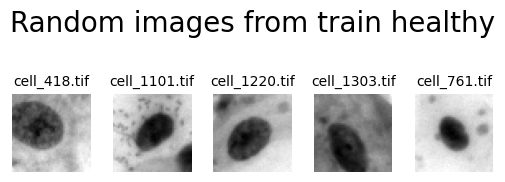

In [10]:
plot_helper.show_random_images_hpv_specific(train_healthy_directory)

## Other setup

In [11]:
x_len = 48
y_len = 48
batch_size = 32
n_epochs = 60

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print('TRAINING DATA:')
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

print('')
print('VALIDATION DATA:')
validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False)

print('')
print('TEST DATA:')
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False)

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)
class_weights = dict(enumerate(class_weights_array))


train_steps = (len(os.listdir(train_healthy_directory)) + len(os.listdir(train_tumor_directory))) // batch_size
validation_steps = (len(os.listdir(validation_healthy_directory)) + len(os.listdir(validation_tumor_directory))) // batch_size
test_steps = (len(os.listdir(test_healthy_directory)) + len(os.listdir(test_tumor_directory))) // batch_size


TRAINING DATA:
Found 2052 images belonging to 2 classes.

VALIDATION DATA:
Found 540 images belonging to 2 classes.

TEST DATA:
Found 637 images belonging to 2 classes.


# STUDENT CODE BEGINS

# A first-try neural network

# Final neural network

## Explain why your chose the architecture you did, and the extra steps you took
If you made more than 2 neural networks, you only need to show the first and last one. Do motivate any changes in between the two, in short sentences so that I can see that you know why you did what you did

# Questions and answers